# BA x AI Final Project (Option A): Pre‑Call Targeting for Bank Telemarketing

This notebook implements **Steps 1–3** from `OptionA_DirectMarketing_TechnicalPlan.md`:

1. Define the **technical outputs** required for the project.
2. Set up a **reproducible environment** (seeds + package versions).
3. **Fetch the dataset** and print **data provenance** + a compact dataset snapshot.

> Note: If `ucimlrepo` is not installed in your environment, install it before running Step 3.


In [38]:
# Step 1 — Required technical outputs (high level)

PROJECT_OUTPUTS = {
    "provenance": [
        "dataset source URL + DOI + licence + access date",
        "rows/features + target definition + class balance",
        "Option A feature availability table (included vs excluded)",
    ],
    "models": [
        "Dummy baseline",
        "Logistic regression (interpretable)",
        "One tree-based model (nonlinear)",
        "(Optional) calibrated probabilities",
    ],
    "evaluation": [
        "PR curve + PR-AUC (primary)",
        "ROC curve + ROC-AUC (secondary)",
        "Calibration curve + Brier score",
        "Lift/gains and precision@K / recall@K",
        "Profit curves vs K and vs threshold + sensitivity over (P, C)",
    ],
    "interpretation": [
        "Top logistic coefficients (business-readable)",
        "Permutation importance for tree model",
    ],
    "reproducibility": [
        "random seeds",
        "train/validation/test split details",
        "model hyperparameters",
        "package versions",
    ],
}

for section, items in PROJECT_OUTPUTS.items():
    print(f"\n{section.upper()}")
    for item in items:
        print(f"- {item}")



PROVENANCE
- dataset source URL + DOI + licence + access date
- rows/features + target definition + class balance
- Option A feature availability table (included vs excluded)

MODELS
- Dummy baseline
- Logistic regression (interpretable)
- One tree-based model (nonlinear)
- (Optional) calibrated probabilities

EVALUATION
- PR curve + PR-AUC (primary)
- ROC curve + ROC-AUC (secondary)
- Calibration curve + Brier score
- Lift/gains and precision@K / recall@K
- Profit curves vs K and vs threshold + sensitivity over (P, C)

INTERPRETATION
- Top logistic coefficients (business-readable)
- Permutation importance for tree model

REPRODUCIBILITY
- random seeds
- train/validation/test split details
- model hyperparameters
- package versions


In [39]:
# Step 2 — Environment & reproducibility setup

import os
import platform
import random
import subprocess
import sys
from datetime import datetime, timezone
import importlib.metadata as md
import importlib.util

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)

ACCESS_UTC = datetime.now(timezone.utc)

# Install (once) any missing libraries used in the project.
# Keeping this in one place makes later cells cleaner and easier to read.
REQUIRED = {
    "numpy": "numpy",
    "pandas": "pandas",
    "ucimlrepo": "ucimlrepo",
    "sklearn": "scikit-learn",
    "matplotlib": "matplotlib",
    "seaborn": "seaborn",
    "IPython": "ipython",
}

missing_dists = sorted({dist for mod, dist in REQUIRED.items() if importlib.util.find_spec(mod) is None})
if missing_dists:
    print("Installing missing packages:", ", ".join(missing_dists))
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", *missing_dists])

missing_mods = [mod for mod in REQUIRED if importlib.util.find_spec(mod) is None]
if missing_mods:
    raise ModuleNotFoundError(
        "Missing required modules after installation: " + ", ".join(missing_mods)
    )

import numpy as np
import pandas as pd

np.random.seed(SEED)

def pkg_version(dist_name: str) -> str:
    try:
        return md.version(dist_name)
    except md.PackageNotFoundError:
        return "not-installed"

env_info = {
    "python": sys.version.split()[0],
    "platform": platform.platform(),
    "seed": SEED,
    "accessed_utc": ACCESS_UTC.isoformat(timespec="seconds"),
    "numpy": pkg_version("numpy"),
    "pandas": pkg_version("pandas"),
    "scikit-learn": pkg_version("scikit-learn"),
    "matplotlib": pkg_version("matplotlib"),
    "seaborn": pkg_version("seaborn"),
    "ucimlrepo": pkg_version("ucimlrepo"),
}

print("Environment / Reproducibility Info")
for k, v in env_info.items():
    print(f"- {k}: {v}")


Environment / Reproducibility Info
- python: 3.11.14
- platform: macOS-26.2-arm64-arm-64bit
- seed: 42
- accessed_utc: 2026-01-06T04:06:16+00:00
- numpy: 2.4.0
- pandas: 2.3.3
- scikit-learn: 1.8.0
- matplotlib: 3.10.8
- seaborn: 0.13.2
- ucimlrepo: 0.0.7


## Step 3 — Data Ingest and Provenance

This cell fetches the UCI **Bank Marketing** dataset (id=222) via `ucimlrepo` and prints:
- A provenance block (source URLs, DOI, licence, access timestamp) for referencing
- A compact dataset snapshot (shape, target balance, and top missingness rates)
- The variable information table provided by UCI metadata


In [40]:
# Step 3 — Data ingest + provenance report (UCI Bank Marketing, id=222)

from ucimlrepo import fetch_ucirepo
from IPython.display import display

DATASET_ID = 222

try:
    bank_marketing = fetch_ucirepo(id=DATASET_ID)
except Exception as e:
    raise RuntimeError(
        "Failed to fetch UCI dataset id=222 via ucimlrepo. "
        "Check your internet access (or whether the dataset is cached in your environment)."
    ) from e

# Data
X_raw = bank_marketing.data.features.copy()
y_raw = bank_marketing.data.targets.iloc[:, 0].copy()

# Provenance (for assignment reporting)
provenance = {
    "dataset_name": bank_marketing.metadata.get("name", "Bank Marketing"),
    "uci_id": bank_marketing.metadata.get("uci_id", DATASET_ID),
    "repository_url": bank_marketing.metadata.get(
        "repository_url", "https://archive.ics.uci.edu/dataset/222/bank+marketing"
    ),
    "data_url": bank_marketing.metadata.get(
        "data_url", "https://archive.ics.uci.edu/static/public/222/data.csv"
    ),
    "dataset_doi": bank_marketing.metadata.get("dataset_doi", "10.24432/C5K306"),
    "licence": "CC BY 4.0 (as listed on UCI)",
    "accessed_utc": ACCESS_UTC.isoformat(timespec="seconds"),
}

print("Data provenance")
for k, v in provenance.items():
    print(f"- {k}: {v}")

print("\nDataset snapshot")
print(f"- rows: {X_raw.shape[0]:,}")
print(f"- features: {X_raw.shape[1]}")
print(f"- feature columns: {list(X_raw.columns)}")

target_counts = y_raw.value_counts(dropna=False)
positive_rate = float((y_raw == "yes").mean()) if y_raw.dtype == object else float("nan")
print("\nTarget distribution (y)")
display(target_counts.to_frame(name="count"))
print(f"- positive rate (y == 'yes'): {positive_rate:.4f}")

print("\nMissingness (NaN) — top columns")
missing_rate = X_raw.isna().mean().sort_values(ascending=False)
missing_tbl = (
    missing_rate[missing_rate > 0]
    .mul(100)
    .round(2)
    .rename("missing_%")
    .to_frame()
)
display(missing_tbl.head(10))

print("\nVariable information (from UCI metadata)")
display(bank_marketing.variables)


Data provenance
- dataset_name: Bank Marketing
- uci_id: 222
- repository_url: https://archive.ics.uci.edu/dataset/222/bank+marketing
- data_url: https://archive.ics.uci.edu/static/public/222/data.csv
- dataset_doi: 10.24432/C5K306
- licence: CC BY 4.0 (as listed on UCI)
- accessed_utc: 2026-01-06T04:06:16+00:00

Dataset snapshot
- rows: 45,211
- features: 16
- feature columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day_of_week', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']

Target distribution (y)


,count
y,
no,39922
yes,5289


- positive rate (y == 'yes'): 0.1170

Missingness (NaN) — top columns


,missing_%
poutcome,81.75
contact,28.80
education,4.11
job,0.64



Variable information (from UCI metadata)


,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,None,no
1,job,Feature,Categorical,Occupation,"type of job (categorical: 'admin.','blue-colla...",None,no
2,marital,Feature,Categorical,Marital Status,"marital status (categorical: 'divorced','marri...",None,no
3,education,Feature,Categorical,Education Level,"(categorical: 'basic.4y','basic.6y','basic.9y'...",None,no
4,default,Feature,Binary,None,has credit in default?,None,no
5,balance,Feature,Integer,None,average yearly balance,euros,no
6,housing,Feature,Binary,None,has housing loan?,None,no
7,loan,Feature,Binary,None,has personal loan?,None,no
8,contact,Feature,Categorical,None,contact communication type (categorical: 'cell...,None,yes
9,day_of_week,Feature,Date,None,last contact day of the week,None,no


## Step 4 — Decision‑Focused EDA (Option A)

Goal: examine the dataset *as a decision problem* and prepare for a **pre‑call targeting** model.

This section focuses on:
- Target imbalance (how rare is subscription?)
- Missingness and what it means in business terms (e.g., no prior campaign history)
- Sanity checks (duplicates, special codes like `pdays` sentinel values)
- A clear **feature availability** table for Option A (what is known *before* calling vs. leakage)


In [41]:
# Step 4 — Data examination (EDA) focused on what matters for the decision

import numpy as np
import pandas as pd
from IPython.display import display

assert "X_raw" in globals() and "y_raw" in globals(), "Run Step 3 first to create X_raw and y_raw."

n_rows = len(X_raw)

print("Dataset overview")
print(f"- rows: {n_rows:,}")
print(f"- features: {X_raw.shape[1]}")
print(f"- target positive rate (y == 'yes'): {(y_raw == 'yes').mean():.4f}")

print("\nDuplicate checks")
print(f"- duplicate rows in features (X_raw): {int(X_raw.duplicated().sum())}")
print(f"- duplicate rows in (X_raw, y_raw): {int(pd.concat([X_raw, y_raw.rename('y')], axis=1).duplicated().sum())}")

print("\nMissingness and cardinality summary")
summary = pd.DataFrame(
    {
        "dtype": X_raw.dtypes.astype(str),
        "n_missing": X_raw.isna().sum(),
        "missing_%": (X_raw.isna().mean() * 100).round(2),
        "n_unique": X_raw.nunique(dropna=False),
    }
).sort_values(["missing_%", "n_unique"], ascending=[False, False])
display(summary)

categorical_cols = [c for c in X_raw.columns if X_raw[c].dtype == "object"]
numeric_cols = [c for c in X_raw.columns if c not in categorical_cols]

print("\nCategorical columns (top values)")
for col in categorical_cols:
    vc = X_raw[col].value_counts(dropna=False)
    top = vc.head(8).to_frame(name="count")
    top["pct"] = (top["count"] / n_rows * 100).round(2)
    print(f"\n- {col} (unique incl NaN: {int(X_raw[col].nunique(dropna=False))}, missing: {int(X_raw[col].isna().sum())})")
    display(top)

print("\nNumeric columns (summary stats)")
display(X_raw[numeric_cols].describe().T)

# Sanity check: pdays uses a sentinel for "not previously contacted" (commonly -1; some variants use 999).
PDAYS_NO_PREV_SENTINELS = [-1, 999]
if "pdays" in X_raw.columns:
    pdays = X_raw["pdays"]
    print("\nSanity checks: prior contact history (pdays)")
    for v in PDAYS_NO_PREV_SENTINELS:
        cnt = int((pdays == v).sum())
        if cnt:
            print(f"- pdays == {v} count (not previously contacted sentinel): {cnt:,} ({cnt / n_rows:.2%})")
    pdays_clean = pdays.where(~pdays.isin(PDAYS_NO_PREV_SENTINELS), np.nan)
    if pdays_clean.notna().any():
        display(pdays_clean.dropna().describe().to_frame(name="pdays (excluding sentinels)"))

# Business meaning of missingness: poutcome is often missing when there was no prior campaign.
if "poutcome" in X_raw.columns and "pdays" in X_raw.columns:
    pdays_clean = X_raw["pdays"].where(~X_raw["pdays"].isin(PDAYS_NO_PREV_SENTINELS), np.nan)
    prev_contacted = pdays_clean.notna()
    poutcome_missing = X_raw["poutcome"].isna() | (X_raw["poutcome"].astype(str).str.lower() == "unknown")
    ctab = pd.crosstab(prev_contacted, poutcome_missing, normalize="index")
    ctab.index = ctab.index.map({False: "prev_contacted = 0", True: "prev_contacted = 1"})
    if list(ctab.columns) == [False, True]:
        ctab.columns = ["poutcome present", "poutcome missing"]
    print("\nMissingness meaning check (poutcome vs prior contact)")
    display(ctab.round(3))

# Leakage illustration (do not use duration in Option A): it is only known after the call.
if "duration" in X_raw.columns:
    leak_tbl = (
        pd.DataFrame({"duration": X_raw["duration"], "y": y_raw})
        .groupby("y")["duration"]
        .agg(["count", "mean", "median"])
    )
    print("\nLeakage check (duration differs sharply by outcome; excluded in Option A)")
    display(leak_tbl)

# Option A feature availability table (include vs exclude)
OPTION_A_INCLUDE = [
    "age",
    "job",
    "marital",
    "education",
    "default",
    "balance",
    "housing",
    "loan",
    "pdays",
    "previous",
    "poutcome",
]

OPTION_A_EXCLUDE = {
    "duration": "Post-call variable (only known after placing the call) → leakage.",
    "campaign": "Depends on how many times the client is contacted during the campaign (not known pre-call).",
    "contact": "Operational/scheduling detail from the last contact (not a stable pre-call customer attribute).",
    "month": "Timing of the last contact; in Option A we assume targeting is decided before scheduling.",
    "day_of_week": "Last contact day of the week; excluded because Option A decides targeting before scheduling.",
}

missing_in_include = [c for c in OPTION_A_INCLUDE if c not in X_raw.columns]
if missing_in_include:
    raise KeyError(f"Option A expected columns not found in X_raw: {missing_in_include}")

availability_rows = []
for feature in X_raw.columns:
    if feature in OPTION_A_INCLUDE:
        availability_rows.append(
            {
                "feature": feature,
                "option_a": "include",
                "availability": "Known pre-call (CRM / account / prior-campaign history)",
                "rationale": "Eligible for pre-call propensity scoring.",
            }
        )
    elif feature in OPTION_A_EXCLUDE:
        availability_rows.append(
            {
                "feature": feature,
                "option_a": "exclude",
                "availability": "Not reliably known pre-call / depends on call execution",
                "rationale": OPTION_A_EXCLUDE[feature],
            }
        )
    else:
        availability_rows.append(
            {
                "feature": feature,
                "option_a": "exclude",
                "availability": "Not used in Option A",
                "rationale": "Excluded to keep the model aligned to the pre-call decision moment.",
            }
        )

feature_availability = pd.DataFrame(availability_rows)
feature_availability["missing_%"] = feature_availability["feature"].map(
    lambda c: round(float(X_raw[c].isna().mean() * 100), 2)
)
feature_availability["option_a_order"] = (
    feature_availability["option_a"].map({"include": 0, "exclude": 1}).fillna(9).astype(int)
)
feature_availability = (
    feature_availability.sort_values(
        ["option_a_order", "missing_%", "feature"], ascending=[True, False, True]
    ).drop(columns=["option_a_order"])
)

print("\nOption A feature availability (include vs exclude)")
display(feature_availability)

print("\nNext: Step 5 will engineer features (e.g., prev_contacted) and build a leakage-safe preprocessing pipeline.")


Dataset overview
- rows: 45,211
- features: 16
- target positive rate (y == 'yes'): 0.1170

Duplicate checks
- duplicate rows in features (X_raw): 0
- duplicate rows in (X_raw, y_raw): 0

Missingness and cardinality summary


,dtype,n_missing,missing_%,n_unique
poutcome,object,36959,81.75,4
contact,object,13020,28.80,3
education,object,1857,4.11,4
job,object,288,0.64,12
balance,int64,0,0.00,7168
duration,int64,0,0.00,1573
pdays,int64,0,0.00,559
age,int64,0,0.00,77
campaign,int64,0,0.00,48
previous,int64,0,0.00,41



Categorical columns (top values)

- job (unique incl NaN: 12, missing: 288)


,count,pct
job,,
blue-collar,9732,21.53
management,9458,20.92
technician,7597,16.80
admin.,5171,11.44
services,4154,9.19
retired,2264,5.01
self-employed,1579,3.49
entrepreneur,1487,3.29



- marital (unique incl NaN: 3, missing: 0)


,count,pct
marital,,
married,27214,60.19
single,12790,28.29
divorced,5207,11.52



- education (unique incl NaN: 4, missing: 1857)


,count,pct
education,,
secondary,23202,51.32
tertiary,13301,29.42
primary,6851,15.15
NaN,1857,4.11



- default (unique incl NaN: 2, missing: 0)


,count,pct
default,,
no,44396,98.2
yes,815,1.8



- housing (unique incl NaN: 2, missing: 0)


,count,pct
housing,,
yes,25130,55.58
no,20081,44.42



- loan (unique incl NaN: 2, missing: 0)


,count,pct
loan,,
no,37967,83.98
yes,7244,16.02



- contact (unique incl NaN: 3, missing: 13020)


,count,pct
contact,,
cellular,29285,64.77
NaN,13020,28.80
telephone,2906,6.43



- month (unique incl NaN: 12, missing: 0)


,count,pct
month,,
may,13766,30.45
jul,6895,15.25
aug,6247,13.82
jun,5341,11.81
nov,3970,8.78
apr,2932,6.49
feb,2649,5.86
jan,1403,3.10



- poutcome (unique incl NaN: 4, missing: 36959)


,count,pct
poutcome,,
NaN,36959,81.75
failure,4901,10.84
other,1840,4.07
success,1511,3.34



Numeric columns (summary stats)


,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day_of_week,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0



Sanity checks: prior contact history (pdays)
- pdays == -1 count (not previously contacted sentinel): 36,954 (81.74%)


,pdays (excluding sentinels)
count,8257.000000
mean,224.577692
std,115.344035
min,1.000000
25%,133.000000
50%,194.000000
75%,327.000000
max,871.000000



Missingness meaning check (poutcome vs prior contact)


,poutcome present,poutcome missing
pdays,,
prev_contacted = 0,0.000,1.000
prev_contacted = 1,0.999,0.001



Leakage check (duration differs sharply by outcome; excluded in Option A)


,count,mean,median
y,,,
no,39922,221.182806,164.0
yes,5289,537.294574,426.0



Option A feature availability (include vs exclude)


,feature,option_a,availability,rationale,missing_%
15,poutcome,include,Known pre-call (CRM / account / prior-campaign...,Eligible for pre-call propensity scoring.,81.75
3,education,include,Known pre-call (CRM / account / prior-campaign...,Eligible for pre-call propensity scoring.,4.11
1,job,include,Known pre-call (CRM / account / prior-campaign...,Eligible for pre-call propensity scoring.,0.64
0,age,include,Known pre-call (CRM / account / prior-campaign...,Eligible for pre-call propensity scoring.,0.00
5,balance,include,Known pre-call (CRM / account / prior-campaign...,Eligible for pre-call propensity scoring.,0.00
4,default,include,Known pre-call (CRM / account / prior-campaign...,Eligible for pre-call propensity scoring.,0.00
6,housing,include,Known pre-call (CRM / account / prior-campaign...,Eligible for pre-call propensity scoring.,0.00
7,loan,include,Known pre-call (CRM / account / prior-campaign...,Eligible for pre-call propensity scoring.,0.00
2,marital,include,Known pre-call (CRM / account / prior-campaign...,Eligible for pre-call propensity scoring.,0.00
13,pdays,include,Known pre-call (CRM / account / prior-campaign...,Eligible for pre-call propensity scoring.,0.00



Next: Step 5 will engineer features (e.g., prev_contacted) and build a leakage-safe preprocessing pipeline.


### Step 4 (Plots) — Visual EDA for the decision story

The presentation benefits from a few clean visuals that directly support the decision framing:
- Class imbalance (subscriptions are rare)
- Missingness patterns (e.g., prior campaign history)
- Evidence that some **pre‑call** fields are useful signals (e.g., prior outcome, credit/loan indicators)

Plots use `matplotlib`/`seaborn`, installed earlier in **Step 2**.


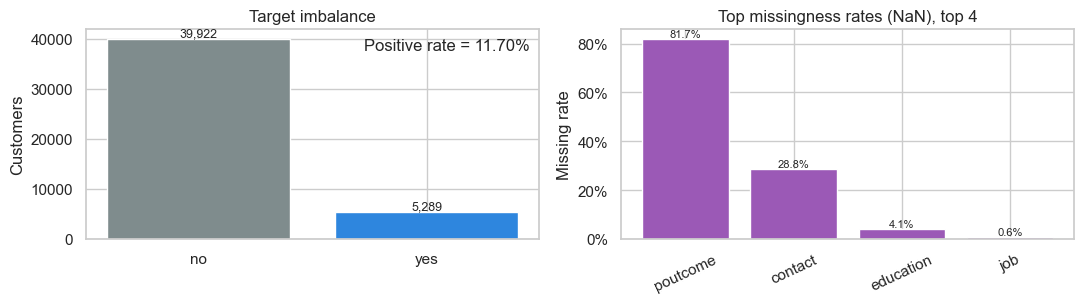

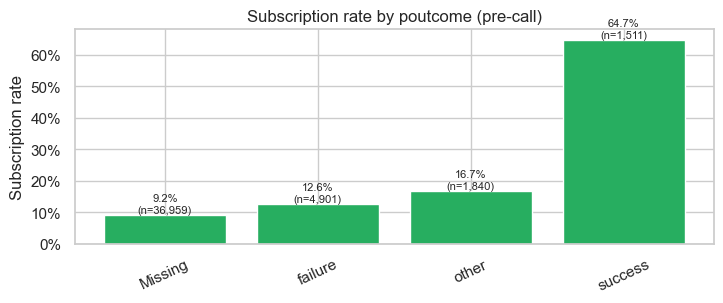

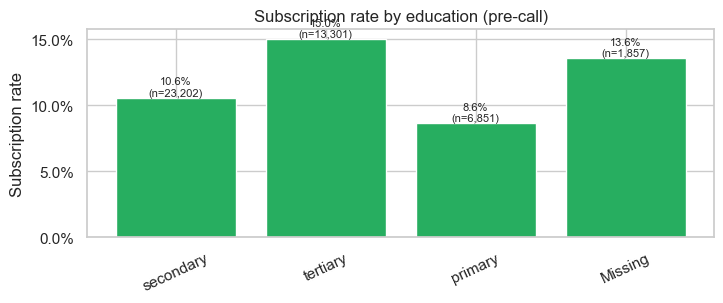

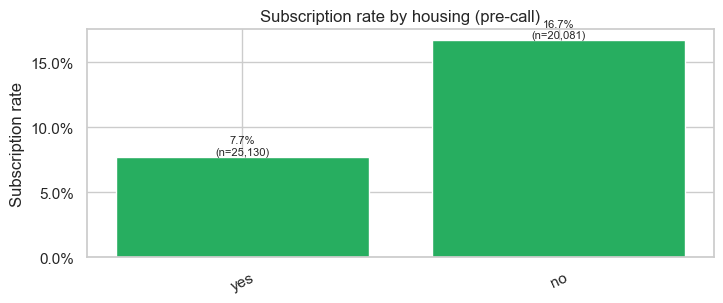

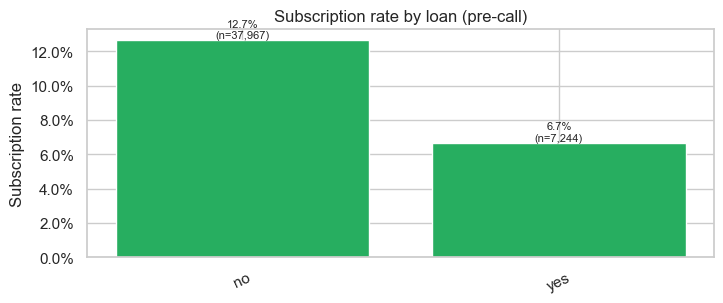

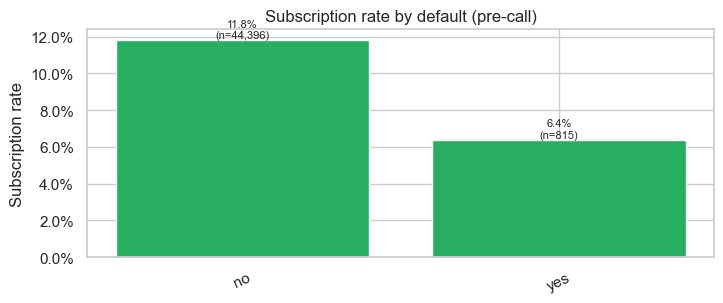

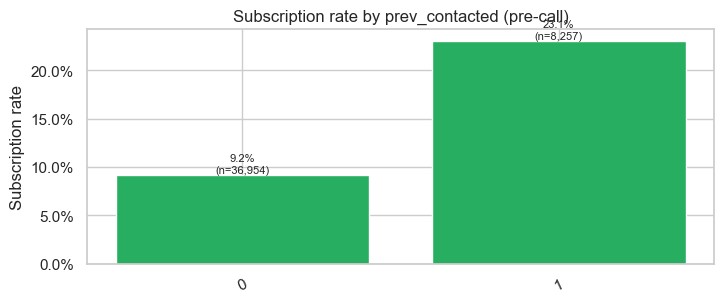

/var/folders/vw/p_gkg8fj4qnd_0h383bdw55h0000gn/T/ipykernel_69250/1313909797.py:82: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([x0, x1], labels=["no", "yes"], showfliers=False)
/var/folders/vw/p_gkg8fj4qnd_0h383bdw55h0000gn/T/ipykernel_69250/1313909797.py:82: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([x0, x1], labels=["no", "yes"], showfliers=False)


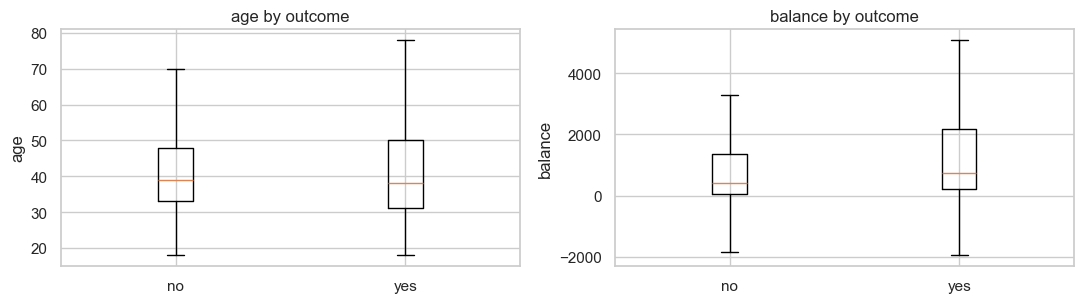

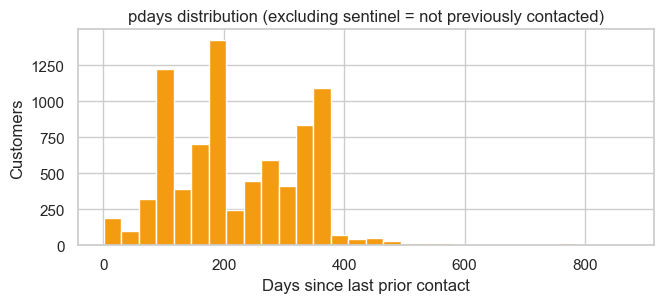

In [42]:
# Step 4 — EDA plots (decision-focused)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

assert "X_raw" in globals() and "y_raw" in globals(), "Run Step 3 first to create X_raw and y_raw."

sns.set_theme(style="whitegrid")

y_bin = (y_raw == "yes").astype(int)
df = X_raw.copy()
df["y"] = y_bin

PDAYS_NO_PREV_SENTINELS = {-1, 999}
pdays_clean = df["pdays"].where(~df["pdays"].isin(PDAYS_NO_PREV_SENTINELS), np.nan)
df["pdays_clean"] = pdays_clean
df["prev_contacted"] = pdays_clean.notna().astype(int)

def plot_target_and_missingness(X: pd.DataFrame, y01: pd.Series, top_n: int = 6) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(11, 3.2))

    # Target imbalance
    counts = y01.value_counts().sort_index()
    labels = ["no", "yes"]
    axes[0].bar(labels, counts.values, color=["#7f8c8d", "#2e86de"])
    axes[0].set_title("Target imbalance")
    axes[0].set_ylabel("Customers")
    for i, v in enumerate(counts.values):
        axes[0].text(i, v, f"{v:,}", ha="center", va="bottom", fontsize=9)
    axes[0].text(0.98, 0.9, f"Positive rate = {float(y01.mean()):.2%}", transform=axes[0].transAxes, ha="right")

    # Missingness
    miss = X.isna().mean().sort_values(ascending=False)
    miss = miss[miss > 0].head(top_n)
    axes[1].bar(miss.index.astype(str), miss.values, color="#9b59b6")
    axes[1].set_title(f"Top missingness rates (NaN), top {len(miss)}")
    axes[1].set_ylabel("Missing rate")
    axes[1].yaxis.set_major_formatter(PercentFormatter(1.0))
    axes[1].tick_params(axis="x", rotation=25)
    for i, v in enumerate(miss.values):
        axes[1].text(i, v, f"{v:.1%}", ha="center", va="bottom", fontsize=8)

    plt.tight_layout()
    plt.show()


def plot_rate_by_category(df0: pd.DataFrame, col: str, top_n: int = 8, min_count: int = 200) -> None:
    s = df0[col].astype(object).where(df0[col].notna(), "Missing")
    agg = (
        df0.assign(_cat=s)
        .groupby("_cat")["y"]
        .agg(rate="mean", n="count")
        .sort_values("n", ascending=False)
    )
    agg = agg[agg["n"] >= min_count].head(top_n)
    if agg.empty:
        print(f"Not enough rows to plot '{col}' (min_count={min_count}).")
        return

    fig, ax = plt.subplots(figsize=(7.4, 3.2))
    ax.bar(agg.index.astype(str), agg["rate"].values, color="#27ae60")
    ax.set_title(f"Subscription rate by {col} (pre-call)")
    ax.set_ylabel("Subscription rate")
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.tick_params(axis="x", rotation=25)
    for i, (rate, n) in enumerate(zip(agg["rate"].values, agg["n"].values)):
        ax.text(i, rate, f"{rate:.1%}\n(n={int(n):,})", ha="center", va="bottom", fontsize=8)
    plt.tight_layout()
    plt.show()


def plot_numeric_boxplots(df0: pd.DataFrame, cols: list[str]) -> None:
    fig, axes = plt.subplots(1, len(cols), figsize=(11, 3.2))
    if len(cols) == 1:
        axes = [axes]
    for ax, col in zip(axes, cols):
        x0 = df0.loc[df0["y"] == 0, col].dropna()
        x1 = df0.loc[df0["y"] == 1, col].dropna()
        ax.boxplot([x0, x1], labels=["no", "yes"], showfliers=False)
        ax.set_title(f"{col} by outcome")
        ax.set_ylabel(col)
    plt.tight_layout()
    plt.show()


def plot_pdays_histogram(df0: pd.DataFrame) -> None:
    s = df0["pdays_clean"].dropna()
    if s.empty:
        print("No prior-contact pdays values to plot (all missing or sentinel).")
        return
    fig, ax = plt.subplots(figsize=(6.8, 3.2))
    ax.hist(s.values, bins=30, color="#f39c12", edgecolor="white")
    ax.set_title("pdays distribution (excluding sentinel = not previously contacted)")
    ax.set_xlabel("Days since last prior contact")
    ax.set_ylabel("Customers")
    plt.tight_layout()
    plt.show()


# Plot A: class imbalance + missingness overview
plot_target_and_missingness(X_raw, y_bin, top_n=6)

# Plot B: subscription rate by key pre-call categorical features
for col in ["poutcome", "education", "housing", "loan", "default", "prev_contacted"]:
    plot_rate_by_category(df, col=col, top_n=8, min_count=200)

# Plot C: numeric distributions by outcome (pre-call)
plot_numeric_boxplots(df, ["age", "balance"])

# Plot D: prior-contact timing distribution
plot_pdays_histogram(df)


## Step 5 — Feature Engineering & Preprocessing (Leakage‑Safe, Option A)

Goal: create the **pre‑call** modeling dataset and define a reusable preprocessing pipeline.

Key points for scoring well:
- The model must match the decision moment (**pre‑call**). We exclude post‑call/execution fields (especially `duration`).
- We handle `pdays` sentinel values explicitly (in this dataset: `-1`):
  - `prev_contacted` indicates whether the customer has prior campaign history.
  - `pdays_clean` replaces sentinels (e.g., `-1`, `999`) with `NaN` so “days since prior contact” is only defined when it exists.
- We use a scikit‑learn `Pipeline`/`ColumnTransformer` to make preprocessing reproducible and leakage‑resistant (fit on training data later).


In [43]:
# Step 5 — Build the Option A (pre-call) modeling frame + preprocessing pipelines

import numpy as np
import pandas as pd
from IPython.display import display

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

assert "X_raw" in globals() and "y_raw" in globals(), "Run Step 3 first to create X_raw and y_raw."
assert "SEED" in globals(), "Run Step 2 first to set SEED."

# Option A: only features plausibly known BEFORE placing the call.
OPTION_A_BASE_FEATURES = [
    "age",
    "job",
    "marital",
    "education",
    "default",
    "balance",
    "housing",
    "loan",
    "pdays",
    "previous",
    "poutcome",
]

missing_cols = [c for c in OPTION_A_BASE_FEATURES if c not in X_raw.columns]
if missing_cols:
    raise KeyError(f"Missing expected Option A columns in X_raw: {missing_cols}")

# Target: convert to 0/1 (positive class = subscribed)
y = (y_raw == "yes").astype(int)

# Start from pre-call features
X = X_raw[OPTION_A_BASE_FEATURES].copy()

# Treat common categorical "unknown" tokens as missing (if present in this dataset)
UNKNOWN_TOKENS = {"unknown", "Unknown", "UNKNOWN"}
for col in X.columns:
    if X[col].dtype == "object":
        X[col] = X[col].where(~X[col].isin(UNKNOWN_TOKENS), np.nan)

# Feature engineering for prior-contact history (pdays uses a sentinel for "not previously contacted")
PDAYS_NO_PREV_SENTINELS = {-1, 999}
pdays_clean = X["pdays"].where(~X["pdays"].isin(PDAYS_NO_PREV_SENTINELS), np.nan)
X["pdays_clean"] = pdays_clean
X["prev_contacted"] = pdays_clean.notna().astype(int)

# Use pdays_clean + prev_contacted instead of raw pdays (sentinel codes).
X_model = X.drop(columns=["pdays"]).copy()

# Define column roles
CATEGORICAL_COLS = ["job", "marital", "education", "default", "housing", "loan", "poutcome"]
NUMERIC_COLS = ["age", "balance", "previous", "pdays_clean", "prev_contacted"]

role_missing = [c for c in CATEGORICAL_COLS + NUMERIC_COLS if c not in X_model.columns]
if role_missing:
    raise KeyError(f"Column-role mapping references missing columns: {role_missing}")

print("Option A modeling frame")
print(f"- X_model shape: {X_model.shape}")
print(f"- y positive rate: {float(y.mean()):.4f}")
print("- categorical cols:", CATEGORICAL_COLS)
print("- numeric cols:", NUMERIC_COLS)

print("\nDtypes and missingness (modeling columns)")
eda_model_summary = pd.DataFrame(
    {
        "dtype": X_model.dtypes.astype(str),
        "missing_%": (X_model.isna().mean() * 100).round(2),
        "n_unique": X_model.nunique(dropna=False),
    }
).loc[CATEGORICAL_COLS + NUMERIC_COLS]
display(eda_model_summary)

# Preprocessing pipelines
categorical_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

# Logistic regression benefits from scaling numeric features.
numeric_pipe_lr = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

# Tree models typically do not need scaling.
numeric_pipe_tree = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])

preprocess_lr = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe_lr, NUMERIC_COLS),
        ("cat", categorical_pipe, CATEGORICAL_COLS),
    ],
    remainder="drop",
)

preprocess_tree = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe_tree, NUMERIC_COLS),
        ("cat", categorical_pipe, CATEGORICAL_COLS),
    ],
    remainder="drop",
)

# Smoke test on a sample ONLY (avoid fitting on the full dataset before splitting).
sample_n = min(2000, len(X_model))
sample_idx = X_model.sample(n=sample_n, random_state=SEED).index
X_sample = X_model.loc[sample_idx]

Xt_lr = clone(preprocess_lr).fit_transform(X_sample)
Xt_tree = clone(preprocess_tree).fit_transform(X_sample)

print("\nPreprocessing smoke test (fit on sample only)")
print(f"- lr design matrix shape: {Xt_lr.shape}")
print(f"- tree design matrix shape: {Xt_tree.shape}")
print("\nNext: Step 6 will create train/validation/test splits and fit these preprocessors ONLY on training data.")


Option A modeling frame
- X_model shape: (45211, 12)
- y positive rate: 0.1170
- categorical cols: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome']
- numeric cols: ['age', 'balance', 'previous', 'pdays_clean', 'prev_contacted']

Dtypes and missingness (modeling columns)


,dtype,missing_%,n_unique
job,object,0.64,12
marital,object,0.00,3
education,object,4.11,4
default,object,0.00,2
housing,object,0.00,2
loan,object,0.00,2
poutcome,object,81.75,4
age,int64,0.00,77
balance,int64,0.00,7168
previous,int64,0.00,41



Preprocessing smoke test (fit on sample only)
- lr design matrix shape: (2000, 34)
- tree design matrix shape: (2000, 34)

Next: Step 6 will create train/validation/test splits and fit these preprocessors ONLY on training data.


## Step 6 — Data Splitting Strategy (Train / Validation / Test)

Goal: create a **held‑out test set** that we do *not* use for model selection.

- **Train (60%)**: fit models and preprocessing.
- **Validation (20%)**: choose hyperparameters and compare models.
- **Test (20%)**: final, unbiased evaluation and business impact estimates.

We use a **stratified** split to preserve the positive rate (~11.7%) in each subset.


In [44]:
# Step 6 — Train/validation/test split (stratified)

import numpy as np
import pandas as pd
from IPython.display import display

from sklearn.model_selection import train_test_split

assert "X_model" in globals() and "y" in globals(), "Run Step 5 first to create X_model and y."
assert "SEED" in globals(), "Run Step 2 first to set SEED."

# 80/20 split first (test is held out)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_model,
    y,
    test_size=0.20,
    random_state=SEED,
    stratify=y,
)

# Split remaining 80% into train/val = 60/20 overall
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25,  # 0.25 * 0.80 = 0.20
    random_state=SEED,
    stratify=y_temp,
)

def split_report(name: str, y_split: pd.Series) -> dict:
    return {
        "split": name,
        "n": int(len(y_split)),
        "positives": int(y_split.sum()),
        "positive_rate": float(y_split.mean()),
    }

report = pd.DataFrame(
    [
        split_report("train", y_train),
        split_report("validation", y_val),
        split_report("test (held out)", y_test),
    ]
)

print("Split summary")
display(report)

# Keep indices (useful for later debugging / reproducibility)
IDX_TRAIN = X_train.index
IDX_VAL = X_val.index
IDX_TEST = X_test.index

print("\nNext: Step 7 will fit models using ONLY the training split and select models using the validation split.")


Split summary


,split,n,positives,positive_rate
0,train,27126,3173,0.116973
1,validation,9042,1058,0.117010
2,test (held out),9043,1058,0.116997



Next: Step 7 will fit models using ONLY the training split and select models using the validation split.


## Step 7 — Modeling (Baseline → Interpretable → Strong)

Goal: build a defensible model ladder aligned to the business decision.

Models:
- **Baseline**: `DummyClassifier` (what happens if we do no ML?)
- **Interpretable**: Logistic Regression (calibrated probabilities, explainable drivers)
- **Stronger**: Random Forest (captures nonlinearities/interactions)

Selection criteria:
- Primary: **PR‑AUC** (best for imbalanced classification)
- Secondary: **ROC‑AUC**
- Business‑aligned: **precision@K / lift@K** for realistic call capacities (computed on validation only)


In [45]:
# Step 7 — Train baseline + candidate models (train only), evaluate on validation

import numpy as np
import pandas as pd
from IPython.display import display

from sklearn.base import clone
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

assert "X_train" in globals() and "X_val" in globals(), "Run Step 6 first to create splits."
assert "preprocess_lr" in globals() and "preprocess_tree" in globals(), "Run Step 5 first to define preprocessors."
assert "SEED" in globals(), "Run Step 2 first to set SEED."

def precision_at_k(y_true: pd.Series, scores: np.ndarray, k: int) -> float:
    k = int(min(k, len(scores)))
    if k <= 0:
        return float("nan")
    order = np.argsort(-scores)[:k]
    return float(np.asarray(y_true)[order].mean())


def evaluate_binary_classifier(estimator, X_eval: pd.DataFrame, y_eval: pd.Series, k_list: list[int]) -> dict:
    proba = estimator.predict_proba(X_eval)[:, 1]
    base_rate = float(np.mean(y_eval))
    out = {
        "pr_auc": float(average_precision_score(y_eval, proba)),
        "roc_auc": float(roc_auc_score(y_eval, proba)),
        "base_rate": base_rate,
    }
    for k in k_list:
        k = int(min(k, len(y_eval)))
        p_at_k = precision_at_k(y_eval, proba, k)
        out[f"precision@{k}"] = p_at_k
        out[f"lift@{k}"] = float(p_at_k / base_rate) if base_rate > 0 else float("nan")
    return out


# Use validation-sized capacities for comparison (keep numbers meaningful for the call-list story)
K_CANDIDATES = [1000, 2000, 5000]
K_CANDIDATES = [k for k in K_CANDIDATES if k <= len(y_val)]
if not K_CANDIDATES:
    K_CANDIDATES = [len(y_val)]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

results = []

# 7.1 Baseline: Dummy (no ML)
dummy = DummyClassifier(strategy="prior")
dummy.fit(X_train, y_train)
dummy_metrics = evaluate_binary_classifier(dummy, X_val, y_val, K_CANDIDATES)
results.append({"model": "Dummy (prior)", **dummy_metrics})

# 7.2 Interpretable model: Logistic Regression (tune C)
lr_pipe = Pipeline(
    steps=[
        ("preprocess", clone(preprocess_lr)),
        (
            "model",
            LogisticRegression(
                max_iter=2000,
                class_weight="balanced",
                solver="liblinear",
            ),
        ),
    ]
)

lr_grid = {
    "model__C": [0.1, 0.3, 1.0, 3.0, 10.0],
}

lr_search = GridSearchCV(
    lr_pipe,
    param_grid=lr_grid,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1,
)
lr_search.fit(X_train, y_train)

best_lr = lr_search.best_estimator_
lr_metrics = evaluate_binary_classifier(best_lr, X_val, y_val, K_CANDIDATES)
results.append(
    {
        "model": "Logistic Regression",
        "cv_pr_auc": float(lr_search.best_score_),
        "best_params": lr_search.best_params_,
        **lr_metrics,
    }
)

# 7.3 Stronger model: Random Forest (tune a small grid)
rf_pipe = Pipeline(
    steps=[
        ("preprocess", clone(preprocess_tree)),
        (
            "model",
            RandomForestClassifier(
                n_estimators=200,
                random_state=SEED,
                n_jobs=-1,
                class_weight="balanced_subsample",
            ),
        ),
    ]
)

rf_grid = {
    "model__max_depth": [None, 10, 20],
    "model__min_samples_leaf": [1, 5],
}

rf_search = GridSearchCV(
    rf_pipe,
    param_grid=rf_grid,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1,
)
rf_search.fit(X_train, y_train)

best_rf = rf_search.best_estimator_
rf_metrics = evaluate_binary_classifier(best_rf, X_val, y_val, K_CANDIDATES)
results.append(
    {
        "model": "Random Forest",
        "cv_pr_auc": float(rf_search.best_score_),
        "best_params": rf_search.best_params_,
        **rf_metrics,
    }
)

# Results table (validation)
results_df = pd.DataFrame(results)
sort_cols = ["pr_auc", "roc_auc"]
results_df = results_df.sort_values(sort_cols, ascending=False)
print("Model comparison (validation set)")
display(results_df)

# Keep the two candidate models for later steps (calibration, test evaluation)
MODEL_DUMMY = dummy
MODEL_LR = best_lr
MODEL_RF = best_rf

print("\nNext: Step 8 will check probability calibration for the selected model(s), then Step 9 will evaluate on the held-out test set.")


/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API.

Model comparison (validation set)


,model,pr_auc,roc_auc,base_rate,precision@1000,lift@1000,precision@2000,lift@2000,precision@5000,lift@5000,cv_pr_auc,best_params
2,Random Forest,0.402671,0.747853,0.11701,0.437,3.734739,0.299,2.555348,0.1684,1.439199,0.362486,"{'model__max_depth': 10, 'model__min_samples_l..."
1,Logistic Regression,0.355265,0.721871,0.11701,0.385,3.290331,0.274,2.341690,0.1640,1.401595,0.340521,{'model__C': 1.0}
0,Dummy (prior),0.117010,0.500000,0.11701,0.110,0.940095,0.115,0.982826,0.1152,0.984535,NaN,NaN



Next: Step 8 will check probability calibration for the selected model(s), then Step 9 will evaluate on the held-out test set.


## Step 8 — Probability Calibration (so profit/threshold logic is defensible)

In Option A we make decisions using predicted probabilities (e.g., call if `p̂ ≥ C/P`). That is only defensible if `p̂` is reasonably **calibrated**.

This step:
- Diagnoses calibration on the **validation** set (reliability curve + Brier score).
- Fits calibrators using **training data only** (CV calibration) and compares `sigmoid` vs `isotonic`.
- Selects the method using **validation Brier score** (and checks PR‑AUC / lift@K don’t collapse).
- Produces the probability model (`MODEL_CALIBRATED`) to use later for profit curves and threshold selection.


,model,val_pr_auc
1,Random Forest,0.402671
0,Logistic Regression,0.355265


Selected model for calibration: Random Forest


,method,val_brier,val_pr_auc
2,isotonic,0.086156,0.401168
1,sigmoid,0.086442,0.403395
0,uncalibrated,0.178173,0.402671


Calibration method selected: isotonic (cv=5)


,base_rate_val,brier_before,brier_after,pr_auc_before,pr_auc_after,precision@1000_before,precision@1000_after,lift@1000_before,lift@1000_after,precision@2000_before,precision@2000_after,lift@2000_before,lift@2000_after,precision@5000_before,precision@5000_after,lift@5000_before,lift@5000_after
0,0.11701,0.178173,0.086156,0.402671,0.401168,0.437,0.426,3.734739,3.64073,0.299,0.2985,2.555348,2.551075,0.1684,0.1686,1.439199,1.440909


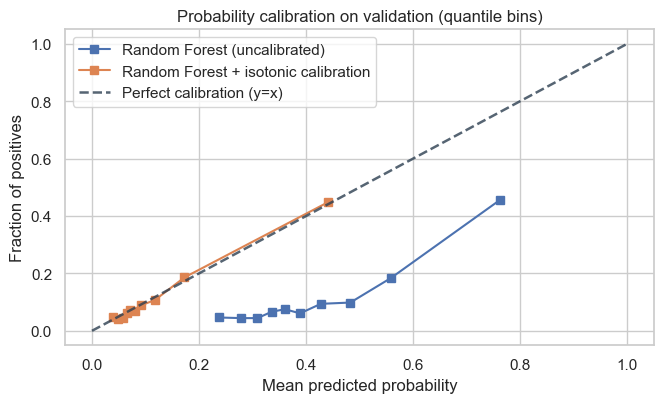


Next: use MODEL_CALIBRATED.predict_proba(...) as p̂ for profit curves and threshold decisions; keep the test set untouched until Step 9.


In [46]:
# Step 8 — Probability calibration (validation diagnostics; train-only calibration)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.base import clone
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.metrics import average_precision_score, brier_score_loss

assert "X_train" in globals() and "y_train" in globals(), "Run Step 6 first to create train split."
assert "X_val" in globals() and "y_val" in globals(), "Run Step 6 first to create validation split."
assert "MODEL_LR" in globals() and "MODEL_RF" in globals(), "Run Step 7 first to train candidate models."

# 8.0 Select the best candidate model on validation PR-AUC (ranking performance)
candidates = {
    "Logistic Regression": MODEL_LR,
    "Random Forest": MODEL_RF,
}

candidate_rows = []
for name, est in candidates.items():
    p_val = est.predict_proba(X_val)[:, 1]
    candidate_rows.append(
        {
            "model": name,
            "val_pr_auc": float(average_precision_score(y_val, p_val)),
        }
    )

candidate_tbl = pd.DataFrame(candidate_rows).sort_values("val_pr_auc", ascending=False)
display(candidate_tbl)

MODEL_SELECTED_NAME = str(candidate_tbl.iloc[0]["model"])
MODEL_SELECTED = candidates[MODEL_SELECTED_NAME]
print(f"Selected model for calibration: {MODEL_SELECTED_NAME}")

# 8.1 Diagnose calibration on validation (before calibration)
p_hat_val = MODEL_SELECTED.predict_proba(X_val)[:, 1]
base_rate_val = float(np.mean(y_val))
brier_before = float(brier_score_loss(y_val, p_hat_val))
pr_auc_before = float(average_precision_score(y_val, p_hat_val))

# 8.2 Calibrate on training only (compare sigmoid vs isotonic; pick best Brier on validation)
CALIBRATION_CV = 5
CALIBRATION_METHODS = ["sigmoid", "isotonic"]

calibration_rows = [
    {
        "method": "uncalibrated",
        "val_brier": brier_before,
        "val_pr_auc": pr_auc_before,
    }
]

calibrators = {}
for method in CALIBRATION_METHODS:
    cal = CalibratedClassifierCV(
        estimator=clone(MODEL_SELECTED),
        method=method,
        cv=CALIBRATION_CV,
    )
    cal.fit(X_train, y_train)
    p_val_cal = cal.predict_proba(X_val)[:, 1]
    calibrators[method] = (cal, p_val_cal)
    calibration_rows.append(
        {
            "method": method,
            "val_brier": float(brier_score_loss(y_val, p_val_cal)),
            "val_pr_auc": float(average_precision_score(y_val, p_val_cal)),
        }
    )

calibration_tbl = pd.DataFrame(calibration_rows).sort_values(
    ["val_brier", "val_pr_auc"],
    ascending=[True, False],
)
display(calibration_tbl)

CALIBRATION_METHOD_SELECTED = str(calibration_tbl.iloc[0]["method"])
if CALIBRATION_METHOD_SELECTED == "uncalibrated":
    MODEL_CALIBRATED = MODEL_SELECTED
    p_hat_val_cal = p_hat_val
else:
    MODEL_CALIBRATED, p_hat_val_cal = calibrators[CALIBRATION_METHOD_SELECTED]

brier_after = float(brier_score_loss(y_val, p_hat_val_cal))
pr_auc_after = float(average_precision_score(y_val, p_hat_val_cal))

print(f"Calibration method selected: {CALIBRATION_METHOD_SELECTED} (cv={CALIBRATION_CV})")

# Sanity check: calibration should improve Brier and not destroy ranking metrics
k_list = globals().get("K_CANDIDATES", [1000, 2000, 5000])
k_list = sorted({int(min(k, len(y_val))) for k in k_list if int(k) > 0})
if not k_list:
    k_list = [len(y_val)]


def _precision_at_k_fallback(y_true: pd.Series, scores: np.ndarray, k: int) -> float:
    k = int(min(k, len(scores)))
    if k <= 0:
        return float("nan")
    order = np.argsort(-scores)[:k]
    return float(np.asarray(y_true)[order].mean())


precision_at_k_fn = globals().get("precision_at_k", _precision_at_k_fallback)

sanity = {
    "base_rate_val": base_rate_val,
    "brier_before": brier_before,
    "brier_after": brier_after,
    "pr_auc_before": pr_auc_before,
    "pr_auc_after": pr_auc_after,
}
for k in k_list:
    p_before = float(precision_at_k_fn(y_val, p_hat_val, k))
    p_after = float(precision_at_k_fn(y_val, p_hat_val_cal, k))
    sanity[f"precision@{k}_before"] = p_before
    sanity[f"precision@{k}_after"] = p_after
    sanity[f"lift@{k}_before"] = float(p_before / base_rate_val) if base_rate_val > 0 else float("nan")
    sanity[f"lift@{k}_after"] = float(p_after / base_rate_val) if base_rate_val > 0 else float("nan")

display(pd.DataFrame([sanity]))

# Reliability diagram (validation): before vs after
fig, ax = plt.subplots(figsize=(6.8, 4.2))
CalibrationDisplay.from_predictions(
    y_val,
    p_hat_val,
    n_bins=10,
    strategy="quantile",
    ref_line=False,
    ax=ax,
    name=f"{MODEL_SELECTED_NAME} (uncalibrated)",
)
if CALIBRATION_METHOD_SELECTED != "uncalibrated":
    CalibrationDisplay.from_predictions(
        y_val,
        p_hat_val_cal,
        n_bins=10,
        strategy="quantile",
        ref_line=False,
        ax=ax,
        name=f"{MODEL_SELECTED_NAME} + {CALIBRATION_METHOD_SELECTED} calibration",
    )
ax.plot([0, 1], [0, 1], linestyle="--", color="#2c3e50", linewidth=1.8, alpha=0.8, label="Perfect calibration (y=x)")
ax.set_title("Probability calibration on validation (quantile bins)")
ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Fraction of positives")
ax.legend(loc="best")
plt.tight_layout()
plt.show()

print(
    "\nNext: use MODEL_CALIBRATED.predict_proba(...) as p̂ for profit curves and threshold decisions; keep the test set untouched until Step 9."
)


## Step 9 — Final Evaluation on the Held‑Out Test Set (Metrics + Business Translation)

This is the **final reportable** evaluation. To keep results valid:
- Do **not** change hyperparameters, calibration method, thresholds, or choose K based on test results.
- Use the test set exactly once to report performance and business impact.

We report:
- ML performance: PR‑AUC (primary) and ROC‑AUC (secondary).
- Targeting impact: lift/gains and precision@K/recall@K.
- Profit impact under explicit assumptions `(P, C)` using **calibrated** probabilities (`MODEL_CALIBRATED`).


,model,n_test,positives_test,test_base_rate,test_pr_auc,test_roc_auc
0,Random Forest,9043,1058,0.116997,0.379196,0.736474


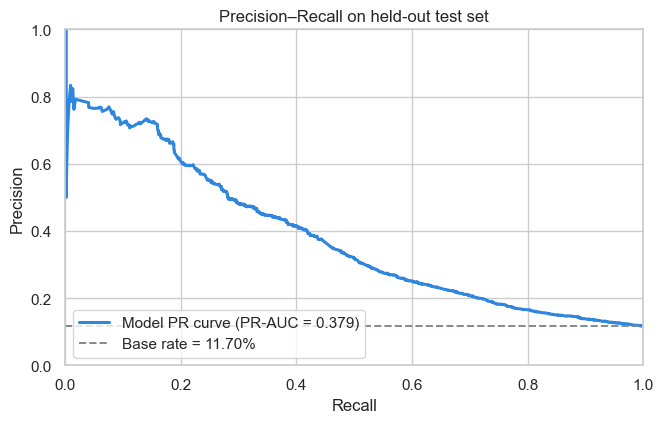

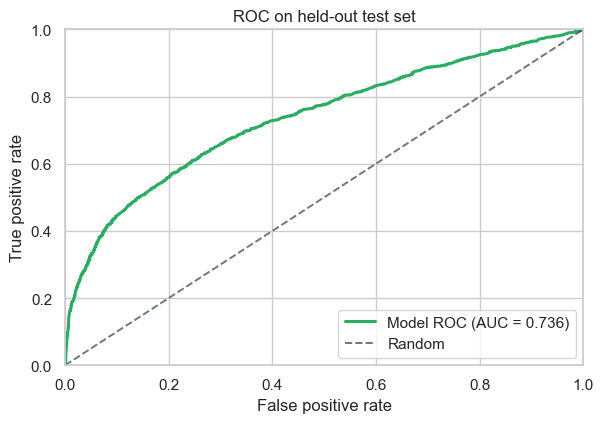

,K,TP,precision@K,recall@K,lift@K,expected_pos_random,incremental_pos_vs_random
0,1000,417,0.4170,0.394140,3.564207,116.996572,300.003428
1,2000,569,0.2845,0.537807,2.431695,233.993144,335.006856
2,5000,836,0.1672,0.790170,1.429102,584.982860,251.017140


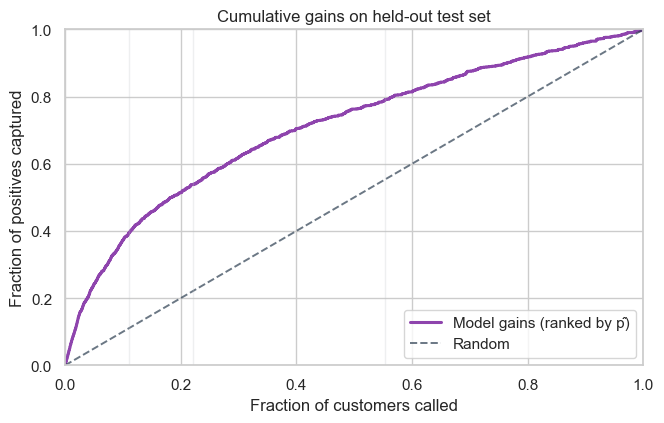

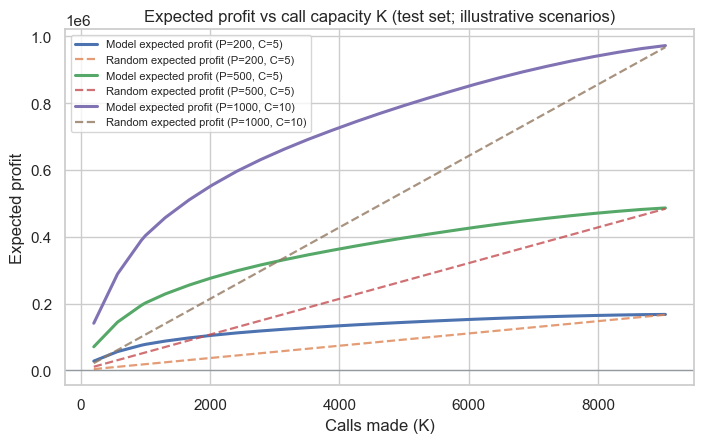

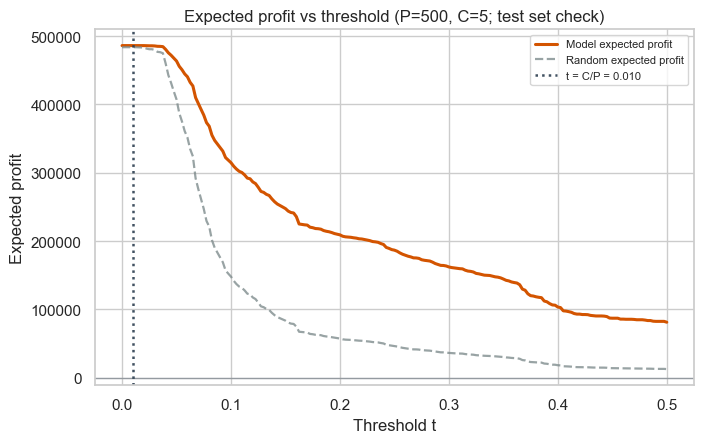

,policy,K_or_t,P,C,calls,TP,profit_realised,profit_expected,profit_expected_random,profit_expected_uplift_vs_random
0,topK,5000.000,200.0,5.0,5000,836,142200.0,143554.437791,91996.571934,51557.865856
1,threshold,0.025,200.0,5.0,8988,1054,165860.0,167374.971139,165373.037709,2001.933430
2,topK,5000.000,500.0,5.0,5000,836,393000.0,396386.094476,267491.429835,128894.664641
3,threshold,0.010,500.0,5.0,9043,1058,483785.0,486156.860512,483785.000000,2371.860512
4,topK,5000.000,1000.0,10.0,5000,836,786000.0,792772.188953,534982.859670,257789.329282
5,threshold,0.010,1000.0,10.0,9043,1058,967570.0,972313.721023,967570.000000,4743.721023



Note: The threshold sweep above is a descriptive out-of-sample check. The recommended threshold policy should be justified by t=C/P (economics) and chosen using validation, not by maximising test profit.


In [47]:
# Step 9 — Final evaluation on held-out test set

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)

assert "X_test" in globals() and "y_test" in globals(), "Run Step 6 first to create X_test/y_test."
assert "MODEL_CALIBRATED" in globals(), "Run Step 8 first to create MODEL_CALIBRATED."

# Predicted probabilities on the held-out test set
p_hat_test = MODEL_CALIBRATED.predict_proba(X_test)[:, 1]
base_rate_test = float(np.mean(y_test))
n_test = int(len(y_test))
positives_test = int(np.sum(y_test))

# 9.1 Standard ML evaluation
pr_auc_test = float(average_precision_score(y_test, p_hat_test))
roc_auc_test = float(roc_auc_score(y_test, p_hat_test))
metrics_tbl = pd.DataFrame(
    [
        {
            "model": globals().get("MODEL_SELECTED_NAME", "selected+calibrated"),
            "n_test": n_test,
            "positives_test": positives_test,
            "test_base_rate": base_rate_test,
            "test_pr_auc": pr_auc_test,
            "test_roc_auc": roc_auc_test,
        }
    ]
)
display(metrics_tbl)

# PR curve (slide-ready)
precision, recall, _ = precision_recall_curve(y_test, p_hat_test)
fig, ax = plt.subplots(figsize=(6.8, 4.4))
ax.plot(recall, precision, color="#2e86de", linewidth=2.2, label=f"Model PR curve (PR-AUC = {pr_auc_test:.3f})")
ax.hlines(base_rate_test, 0, 1, linestyle="--", color="#7f8c8d", linewidth=1.4, label=f"Base rate = {base_rate_test:.2%}")
ax.set_title("Precision–Recall on held-out test set")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()

# ROC curve (secondary)
fpr, tpr, _ = roc_curve(y_test, p_hat_test)
fig, ax = plt.subplots(figsize=(6.2, 4.4))
ax.plot(fpr, tpr, color="#27ae60", linewidth=2.2, label=f"Model ROC (AUC = {roc_auc_test:.3f})")
ax.plot([0, 1], [0, 1], linestyle="--", color="#2c3e50", linewidth=1.4, alpha=0.7, label="Random")
ax.set_title("ROC on held-out test set")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

# 9.2 Capacity-based targeting (top-K)
K_LIST = [1000, 2000, 5000, 10000]
K_LIST = [k for k in K_LIST if k <= n_test]
if not K_LIST:
    K_LIST = [n_test]

order = np.argsort(-p_hat_test)
y_sorted = np.asarray(y_test)[order]
p_sorted = np.asarray(p_hat_test)[order]
cum_tp = np.cumsum(y_sorted)
cum_p = np.cumsum(p_sorted)
total_pos = int(np.sum(y_sorted))

topk_rows = []
for k in K_LIST:
    tp_k = int(cum_tp[k - 1])
    precision_k = float(tp_k / k) if k > 0 else float("nan")
    recall_k = float(tp_k / total_pos) if total_pos > 0 else float("nan")
    lift_k = float(precision_k / base_rate_test) if base_rate_test > 0 else float("nan")
    expected_random_pos = float(k * base_rate_test)
    incremental_pos = float(tp_k - expected_random_pos)
    topk_rows.append(
        {
            "K": int(k),
            "TP": tp_k,
            "precision@K": precision_k,
            "recall@K": recall_k,
            "lift@K": lift_k,
            "expected_pos_random": expected_random_pos,
            "incremental_pos_vs_random": incremental_pos,
        }
    )

topk_tbl = pd.DataFrame(topk_rows)
display(topk_tbl)

# Gains curve (slide-ready): fraction of positives captured vs fraction of customers called
if total_pos > 0:
    x = (np.arange(1, n_test + 1) / n_test)
    gains = cum_tp / total_pos
    fig, ax = plt.subplots(figsize=(6.8, 4.4))
    ax.plot(x, gains, color="#8e44ad", linewidth=2.2, label="Model gains (ranked by p̂)")
    ax.plot([0, 1], [0, 1], linestyle="--", color="#2c3e50", linewidth=1.4, alpha=0.7, label="Random")
    for k in K_LIST:
        ax.axvline(k / n_test, color="#bdc3c7", linewidth=1.0, alpha=0.25)
    ax.set_title("Cumulative gains on held-out test set")
    ax.set_xlabel("Fraction of customers called")
    ax.set_ylabel("Fraction of positives captured")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# 9.3 Profit analysis (explicit assumptions)
# IMPORTANT: These are assumptions for business translation (not provided by the dataset).
# Replace with your best estimates / ranges and justify them in the slides.
PLOT_SCENARIOS = [(200, 5), (500, 5), (1000, 10)]  # (P profit per success, C cost per call)

def expected_profit_random(n_calls: int, base_rate: float, P: float, C: float) -> float:
    return float(n_calls * (base_rate * P - C))


def profit_top_k(k: int, P: float, C: float) -> dict:
    tp = int(cum_tp[k - 1])
    sum_p = float(cum_p[k - 1])
    realised = float(tp * P - k * C)
    expected = float(sum_p * P - k * C)
    baseline = expected_profit_random(k, base_rate_test, P, C)
    return {
        "policy": "topK",
        "K_or_t": int(k),
        "P": float(P),
        "C": float(C),
        "calls": int(k),
        "TP": tp,
        "profit_realised": realised,
        "profit_expected": expected,
        "profit_expected_random": baseline,
        "profit_expected_uplift_vs_random": float(expected - baseline),
    }


def profit_threshold(P: float, C: float) -> dict:
    t = float(C / P)
    mask = p_hat_test >= t
    calls = int(np.sum(mask))
    tp = int(np.sum(np.asarray(y_test)[mask]))
    sum_p = float(np.sum(p_hat_test[mask]))
    realised = float(tp * P - calls * C)
    expected = float(sum_p * P - calls * C)
    baseline = expected_profit_random(calls, base_rate_test, P, C)
    return {
        "policy": "threshold",
        "K_or_t": t,
        "P": float(P),
        "C": float(C),
        "calls": calls,
        "TP": tp,
        "profit_realised": realised,
        "profit_expected": expected,
        "profit_expected_random": baseline,
        "profit_expected_uplift_vs_random": float(expected - baseline),
    }


# Profit vs K (expected profit) for a few scenarios
max_k = int(min(10000, n_test))
k_curve = sorted(set([k for k in K_LIST if k <= max_k] + list(np.linspace(200, max_k, 25).round().astype(int))))
k_curve = [k for k in k_curve if 1 <= k <= n_test]

fig, ax = plt.subplots(figsize=(7.2, 4.6))
for (P, C) in PLOT_SCENARIOS:
    model_profit = [profit_top_k(k, P, C)["profit_expected"] for k in k_curve]
    random_profit = [expected_profit_random(k, base_rate_test, P, C) for k in k_curve]
    ax.plot(k_curve, model_profit, linewidth=2.2, label=f"Model expected profit (P={P}, C={C})")
    ax.plot(k_curve, random_profit, linestyle="--", linewidth=1.6, alpha=0.8, label=f"Random expected profit (P={P}, C={C})")
ax.axhline(0, color="#2c3e50", linewidth=1.0, alpha=0.35)
ax.set_title("Expected profit vs call capacity K (test set; illustrative scenarios)")
ax.set_xlabel("Calls made (K)")
ax.set_ylabel("Expected profit")
ax.legend(loc="best", fontsize=8)
plt.tight_layout()
plt.show()

# Profit vs threshold sweep (descriptive out-of-sample check; DO NOT choose t by maximising test profit)
P_EXAMPLE, C_EXAMPLE = 500, 5
t_recommended = float(C_EXAMPLE / P_EXAMPLE)
t_max = float(min(0.5, np.max(p_hat_test)))
thresholds = np.linspace(0.0, t_max, 201)

profit_model = []
profit_random = []
for t in thresholds:
    mask = p_hat_test >= t
    calls = int(np.sum(mask))
    exp_profit = float(np.sum(p_hat_test[mask]) * P_EXAMPLE - calls * C_EXAMPLE)
    profit_model.append(exp_profit)
    profit_random.append(expected_profit_random(calls, base_rate_test, P_EXAMPLE, C_EXAMPLE))

fig, ax = plt.subplots(figsize=(7.2, 4.6))
ax.plot(thresholds, profit_model, color="#d35400", linewidth=2.2, label="Model expected profit")
ax.plot(thresholds, profit_random, color="#7f8c8d", linestyle="--", linewidth=1.6, alpha=0.8, label="Random expected profit")
ax.axvline(t_recommended, color="#2c3e50", linestyle=":", linewidth=1.8, alpha=0.9, label=f"t = C/P = {t_recommended:.3f}")
ax.axhline(0, color="#2c3e50", linewidth=1.0, alpha=0.35)
ax.set_title(f"Expected profit vs threshold (P={P_EXAMPLE}, C={C_EXAMPLE}; test set check)")
ax.set_xlabel("Threshold t")
ax.set_ylabel("Expected profit")
ax.legend(loc="best", fontsize=8)
plt.tight_layout()
plt.show()

# Slide-ready compact tables (illustrative)
K_STAR_ASSUMED = 5000  # set to operational call capacity
K_STAR = int(min(K_STAR_ASSUMED, n_test))
profit_rows = []
for (P, C) in PLOT_SCENARIOS:
    profit_rows.append(profit_top_k(K_STAR, P, C))
    profit_rows.append(profit_threshold(P, C))

profit_tbl = pd.DataFrame(profit_rows)
display(profit_tbl)

print(
    "\nNote: The threshold sweep above is a descriptive out-of-sample check. The recommended threshold policy should be justified by t=C/P (economics) and chosen using validation, not by maximising test profit."
)


## Step 10 — Model Interpretation (turn into business recommendations)

Goal: explain *why* the model ranks some customers higher, without over-claiming causality.

Deliverables (slide-ready):
- Logistic regression: top positive/negative drivers (coefficients) mapped to business language.
- Selected model: permutation importance on the validation set (top ~10 drivers) to support recommendations.

Notes to say in the video:
- These are **associations**, not causal effects.
- We excluded post-call leakage fields (e.g., `duration`) to keep the decision implementable.


Top positive drivers (Logistic Regression; higher propensity):


,feature_clean,coef
33,poutcome=success,1.358291
11,job=retired,0.621273
4,prev_contacted,0.514763
14,job=student,0.512724
26,housing=no,0.267614
23,education=tertiary,0.138939
24,default=no,0.133188
19,marital=single,0.122182
28,loan=no,0.119629
16,job=unemployed,0.118843


Top negative drivers (Logistic Regression; lower propensity):


,feature_clean,coef
31,poutcome=failure,-0.898880
32,poutcome=other,-0.695394
9,job=housemaid,-0.450821
27,housing=yes,-0.391782
5,job=Missing,-0.380048
25,default=yes,-0.257356
18,marital=married,-0.248184
29,loan=yes,-0.243797
7,job=blue-collar,-0.203492
21,education=primary,-0.200387


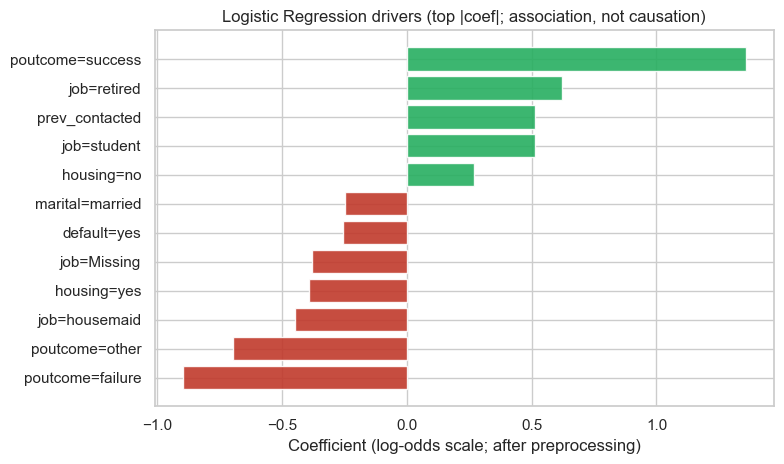

Permutation importance on validation (model = Random Forest; scoring = PR-AUC)


,feature,importance_mean,importance_std
9,poutcome,0.117074,0.004052
6,housing,0.047413,0.004183
0,age,0.023998,0.002167
10,pdays_clean,0.014759,0.001597
5,balance,0.013077,0.003998
8,previous,0.012594,0.001828
7,loan,0.011192,0.003743
11,prev_contacted,0.009698,0.001761
1,job,0.007293,0.004004
2,marital,0.007164,0.001107


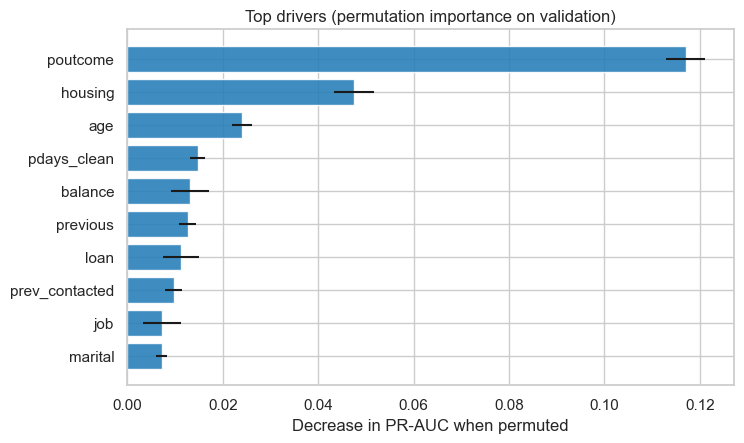

In [48]:
# Step 10 — Interpretation artefacts (drivers)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.inspection import permutation_importance

assert "X_val" in globals() and "y_val" in globals(), "Run Step 6 first to create validation split."
assert "MODEL_SELECTED" in globals() and "MODEL_SELECTED_NAME" in globals(), "Run Step 8 first to select a model."
assert "MODEL_LR" in globals(), "Run Step 7 first to train Logistic Regression."
assert "SEED" in globals(), "Run Step 2 first to set SEED."

def _clean_feature_name(name: str) -> str:
    # Examples: 'num__balance' -> 'balance', 'cat__job_admin.' -> 'job=admin.'
    if name.startswith('num__'):
        return name.replace('num__', '')
    if name.startswith('cat__'):
        rest = name.replace('cat__', '')
        if '_' in rest:
            col, val = rest.split('_', 1)
            return f"{col}={val}"
        return rest
    return name

# 10.1 Logistic regression coefficients (interpretable drivers)
lr = MODEL_LR
pre = lr.named_steps.get('preprocess')
clf = lr.named_steps.get('model')

coef_tbl = None
if pre is not None and clf is not None and hasattr(clf, 'coef_'):
    try:
        feature_names = list(pre.get_feature_names_out())
    except Exception as e:
        feature_names = [f"x{i}" for i in range(clf.coef_.shape[1])]
        print(f"Warning: could not get feature names from preprocessor ({e}).")

    coefs = clf.coef_.ravel()
    coef_tbl = pd.DataFrame(
        {
            'feature': feature_names,
            'feature_clean': [_clean_feature_name(f) for f in feature_names],
            'coef': coefs,
            'abs_coef': np.abs(coefs),
        }
    ).sort_values('abs_coef', ascending=False)

    top_pos = coef_tbl.sort_values('coef', ascending=False).head(10)[['feature_clean', 'coef']]
    top_neg = coef_tbl.sort_values('coef', ascending=True).head(10)[['feature_clean', 'coef']]

    print('Top positive drivers (Logistic Regression; higher propensity):')
    display(top_pos)
    print('Top negative drivers (Logistic Regression; lower propensity):')
    display(top_neg)

    # Optional: bar chart of top coefficients by magnitude
    plot_n = 12
    plot_tbl = coef_tbl.head(plot_n).sort_values('coef')
    fig, ax = plt.subplots(figsize=(8.0, 4.8))
    colors = ['#c0392b' if v < 0 else '#27ae60' for v in plot_tbl['coef']]
    ax.barh(plot_tbl['feature_clean'], plot_tbl['coef'], color=colors, alpha=0.9)
    ax.set_title('Logistic Regression drivers (top |coef|; association, not causation)')
    ax.set_xlabel('Coefficient (log-odds scale; after preprocessing)')
    plt.tight_layout()
    plt.show()
else:
    print('Could not extract logistic regression coefficients (unexpected pipeline structure).')

# 10.2 Permutation importance for the selected model (validation set)
# Uses original features (business-friendly) because the pipeline permutes input columns.
selected = MODEL_SELECTED
importance_sample_n = min(10000, len(X_val))
X_val_imp = X_val
y_val_imp = y_val
if len(X_val) > importance_sample_n:
    X_val_imp = X_val.sample(n=importance_sample_n, random_state=SEED)
    y_val_imp = y_val.loc[X_val_imp.index]

pi = permutation_importance(
    selected,
    X_val_imp,
    y_val_imp,
    n_repeats=5,
    random_state=SEED,
    scoring='average_precision',
    n_jobs=-1,
)

pi_tbl = pd.DataFrame(
    {
        'feature': list(X_val_imp.columns),
        'importance_mean': pi.importances_mean,
        'importance_std': pi.importances_std,
    }
).sort_values('importance_mean', ascending=False)

print(f"Permutation importance on validation (model = {MODEL_SELECTED_NAME}; scoring = PR-AUC)")
display(pi_tbl.head(12))

top_n = 10
plot_pi = pi_tbl.head(top_n).sort_values('importance_mean')
fig, ax = plt.subplots(figsize=(7.6, 4.6))
ax.barh(plot_pi['feature'], plot_pi['importance_mean'], xerr=plot_pi['importance_std'], color='#2980b9', alpha=0.9)
ax.set_title('Top drivers (permutation importance on validation)')
ax.set_xlabel('Decrease in PR-AUC when permuted')
plt.tight_layout()
plt.show()


## Step 11 — Final Recommendation Logic (what you will say in the video)

Goal: turn model scores into a clear, operational decision policy and quantify business impact.

You must state one policy (or two, depending on capacity):
- **Capacity fixed:** call the **top‑K** customers by predicted propensity.
- **Capacity flexible:** call if **`p̂ ≥ t`**, justified by economics: **`t = C/P`**.

Include: lift/precision@K and profit uplift vs random targeting under explicit assumptions `(P, C)`.


In [49]:
# Step 11 — Slide-ready decision policy + business impact (test set)

import importlib.util
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from IPython.display import display

assert "X_test" in globals() and "y_test" in globals(), "Run Step 6 first to create test split."
assert "MODEL_CALIBRATED" in globals(), "Run Step 8 first to create MODEL_CALIBRATED."

# Import targeting metrics helpers from this repo (skill: ba4ai-targeting-metrics)
tm_path = Path('skills/ba4ai-targeting-metrics/scripts/targeting_metrics.py')
spec = importlib.util.spec_from_file_location('targeting_metrics', tm_path)
tm = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = tm
assert spec.loader is not None
spec.loader.exec_module(tm)

# Predicted probabilities (use calibrated model)
p_hat_test = MODEL_CALIBRATED.predict_proba(X_test)[:, 1]
br_test = tm.base_rate(y_test)
n_test = int(len(y_test))

# Choose realistic call capacities (set K* to your operational capacity; do NOT choose it by maximising test profit)
K_LIST = [1000, 2000, 5000, 10000]
K_LIST = [int(k) for k in K_LIST if int(k) > 0 and int(k) <= n_test]
if not K_LIST:
    K_LIST = [n_test]

k_rows = tm.k_metrics_table(y_test, p_hat_test, K_LIST)
k_tbl = pd.DataFrame(tm.to_dicts(k_rows))
print('Capacity targeting metrics on held-out test set')
print(f'- test base rate: {br_test:.4f}')
display(k_tbl[['k','precision_at_k','recall_at_k','lift_at_k','incremental_positives_vs_random']])

# Economics assumptions (illustrative): profit per success P, cost per call C
P_LIST = [200, 500, 1000]
C_LIST = [2, 5, 10]

# Top-K profit table
profit_topk = tm.profit_topk_table(y_test, p_hat_test, K_LIST, P_LIST, C_LIST)
profit_topk_tbl = pd.DataFrame(tm.to_dicts(profit_topk))

# Threshold policy is only defensible if probabilities are reasonably calibrated
cal_method = globals().get('CALIBRATION_METHOD_SELECTED', 'unknown')
if cal_method == 'uncalibrated':
    print('Note: probabilities were not calibrated; avoid claiming a threshold policy is reliable. Use top-K ranking.')
    profit_thr_tbl = None
else:
    profit_thr = tm.profit_threshold_table(y_test, p_hat_test, P_LIST, C_LIST)
    profit_thr_tbl = pd.DataFrame(tm.to_dicts(profit_thr))

# Pick a single K* for the narrative (edit this to match capacity)
K_STAR_ASSUMED = 5000  # set to your operational call capacity
K_STAR = int(min(K_STAR_ASSUMED, n_test))
if K_STAR not in K_LIST:
    K_STAR = K_LIST[-1]

print(f'\nRecommended operational policy (capacity fixed): Call top-K customers with K = {K_STAR}.')
row_k = k_tbl[k_tbl['k'] == K_STAR].iloc[0]
print(f"At K={K_STAR}, precision@K={row_k['precision_at_k']:.3f}, lift@K={row_k['lift_at_k']:.2f}, incremental positives vs random ≈ {row_k['incremental_positives_vs_random']:.1f}.")

# Slide-ready compact profit table for 3 scenarios (align with your Step 9 slide)
SCENARIOS = [(200, 5), (500, 5), (1000, 10)]
rows = []
for (P, C) in SCENARIOS:
    r = profit_topk_tbl[(profit_topk_tbl['k']==K_STAR) & (profit_topk_tbl['p_success']==P) & (profit_topk_tbl['c_call']==C)].iloc[0].to_dict()
    rows.append({
        'policy': 'topK',
        'K_or_t': K_STAR,
        'P': P,
        'C': C,
        'calls': int(r['calls_made']),
        'TP': int(r['tp']),
        'profit_expected_uplift_vs_random': float(r['profit_expected_uplift_vs_random']),
    })

    if profit_thr_tbl is not None:
        rt = profit_thr_tbl[(profit_thr_tbl['p_success']==P) & (profit_thr_tbl['c_call']==C)].iloc[0].to_dict()
        rows.append({
            'policy': 'threshold (t=C/P)',
            'K_or_t': float(rt['threshold']),
            'P': P,
            'C': C,
            'calls': int(rt['calls_made']),
            'TP': int(rt['tp']),
            'profit_expected_uplift_vs_random': float(rt['profit_expected_uplift_vs_random']),
        })

profit_compact_tbl = pd.DataFrame(rows)
print('\nProfit uplift vs random targeting (test set; assumptions must be stated in slides)')
display(profit_compact_tbl)

# What to say (template lines for the video)
print('\nVideo-ready recommendation lines (edit numbers/assumptions as needed):')
print(f"- Decision policy: call the top {K_STAR} customers ranked by propensity score each campaign.")
print(f"- This captures materially more subscriptions than random calling (see lift@K and incremental positives at K={K_STAR}).")
print(f"- Under explicit assumptions for profit per success (P) and cost per call (C), the expected profit uplift vs random targeting is shown above.")
print('- Operationalisation: export ranked list to CRM, call from top down; monitor conversion rate, score drift, and calibration drift; retrain periodically.')


Capacity targeting metrics on held-out test set
- test base rate: 0.1170


,k,precision_at_k,recall_at_k,lift_at_k,incremental_positives_vs_random
0,1000,0.4170,0.394140,3.564207,300.003428
1,2000,0.2850,0.538752,2.435969,336.006856
2,5000,0.1672,0.790170,1.429102,251.017140



Recommended operational policy (capacity fixed): Call top-K customers with K = 5000.
At K=5000, precision@K=0.167, lift@K=1.43, incremental positives vs random ≈ 251.0.

Profit uplift vs random targeting (test set; assumptions must be stated in slides)


,policy,K_or_t,P,C,calls,TP,profit_expected_uplift_vs_random
0,topK,5000.000,200,5,5000,836,51557.865856
1,threshold (t=C/P),0.025,200,5,8988,1054,2001.933430
2,topK,5000.000,500,5,5000,836,128894.664641
3,threshold (t=C/P),0.010,500,5,9043,1058,2371.860512
4,topK,5000.000,1000,10,5000,836,257789.329282
5,threshold (t=C/P),0.010,1000,10,9043,1058,4743.721023



Video-ready recommendation lines (edit numbers/assumptions as needed):
- Decision policy: call the top 5000 customers ranked by propensity score each campaign.
- This captures materially more subscriptions than random calling (see lift@K and incremental positives at K=5000).
- Under explicit assumptions for profit per success (P) and cost per call (C), the expected profit uplift vs random targeting is shown above.
- Operationalisation: export ranked list to CRM, call from top down; monitor conversion rate, score drift, and calibration drift; retrain periodically.


## Step 12 — Slide-ready artefacts checklist (10 minutes)

This section ensures the notebook produces the artefacts listed in `OptionA_DirectMarketing_TechnicalPlan.md`:
- Problem framing
- Data provenance + class balance + missingness highlights
- Feature availability (included/excluded)
- Method pipeline diagram
- PR curve + key metrics
- Lift/gains + precision@K table
- Profit curve + sensitivity
- Recommendations + ops plan + limitations
- References + 1-line GenAI disclosure


In [50]:
# Step 12 — Generate slide-ready blocks (tables + text)

import importlib.util
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from IPython.display import Markdown, display

assert 'provenance' in globals(), 'Run Step 3 first (provenance block). '
assert 'X_model' in globals() and 'y' in globals(), 'Run Step 5 first (modeling frame). '
assert 'MODEL_CALIBRATED' in globals(), 'Run Step 8 first (calibration). '
assert 'X_test' in globals() and 'y_test' in globals(), 'Run Step 6 first (test split). '

# 12.1 Problem framing (paste into slides)
problem_md = """
### Problem framing (Option A: pre-call targeting)

- **Decision:** Which customers should we call next (ranked list + cut-off)?
- **Objective:** Maximise expected campaign value (profit), subject to limited calling capacity.
- **Levers:** call capacity `K`, threshold `t`, ranking policy, agent allocation.
- **Constraints:** limited agent time/budget, compliance/do-not-call, customer experience risk.
- **Assumptions:** profit per success `P` and cost per call `C`; call if `P·p̂ − C > 0` ⇒ `p̂ ≥ C/P`.
"""
display(Markdown(problem_md))

# 12.2 Data provenance (paste into slides)
prov_lines = "\n".join([f"- **{k}**: {v}" for k, v in provenance.items()])
display(Markdown("### Data provenance (UCI Bank Marketing)\n" + prov_lines))

# 12.3 Feature availability table (included vs excluded)
INCLUDED = [
    "age","job","marital","education","default","balance","housing","loan","previous","poutcome",
    "pdays_clean","prev_contacted",
]
EXCLUDED = [
    ("duration", "Post-call / leakage"),
    ("campaign", "Depends on current campaign execution"),
    ("contact", "Operational/execution field (out of scope for pre-call propensity)"),
    ("month", "Operational scheduling/execution (out of scope in Option A)"),
    ("day_of_week", "Operational scheduling/execution (out of scope in Option A)"),
]

feat_rows = []
for f in INCLUDED:
    feat_rows.append({"feature": f, "use": "include", "rationale": "Available pre-call (CRM/prior history)"})
for f, why in EXCLUDED:
    feat_rows.append({"feature": f, "use": "exclude", "rationale": why})
feature_availability_tbl = pd.DataFrame(feat_rows).sort_values(["use","feature"], ascending=[False, True])
display(feature_availability_tbl)

# Guardrail check: ensure excluded columns are not used in the Option A modeling frame
for col, _ in EXCLUDED:
    if col in X_model.columns:
        raise AssertionError(f"Guardrail violated: {col} is present in X_model")

# 12.4 Method pipeline diagram (simple box diagram for slides)
pipeline_md = """
### Method (pipeline diagram)

`X (pre-call features)` → `train/val/test split (stratified, fixed seed)` →
`preprocess (impute + one-hot)` → `model (LR / RF)` → `calibration (train-only CV)` →
`p̂` → `rank customers / choose policy (top-K or t=C/P)` → `lift@K + profit uplift`
"""
display(Markdown(pipeline_md))

# 12.5 References + GenAI disclosure (paste into slides)
genai_line = "GenAI disclosure: I used AI tools to help structure the analysis and draft wording; all results and references were verified by me in the notebook."
refs_md = "\n".join([
    "### References (minimum)",
    "",
    "- UCI Machine Learning Repository — Bank Marketing (id=222), DOI: 10.24432/C5K306, CC BY 4.0.",
    "- scikit-learn documentation (metrics, calibration, permutation importance).",
    "",
    "### GenAI disclosure (one line)",
    "",
    f"- {genai_line}",
])
display(Markdown(refs_md))
# 12.5b Recommendations + limitations (paste into slides)
limitations_md = """
### Recommendations + limitations (one slide)

**Recommendation (capacity fixed):** call the top-K customers ranked by p_hat (K = operational call capacity).

**Operationalisation:** export ranked list to CRM, call from top down; monitor conversion rate, score drift, and calibration drift; retrain periodically.

**Limitations / risks:**
- Historic dataset context; risk of concept drift in future campaigns.
- Option A excludes leakage fields (e.g., duration), which reduces apparent performance but keeps the policy implementable.
- Many customers have limited prior-history signals; richer CRM features would likely improve targeting.
"""
display(Markdown(limitations_md))


# 12.6 Quick “definition of done” numbers (held-out test set)
tm_path = Path("skills/ba4ai-targeting-metrics/scripts/targeting_metrics.py")
spec = importlib.util.spec_from_file_location("targeting_metrics", tm_path)
tm = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = tm
assert spec.loader is not None
spec.loader.exec_module(tm)

p_hat_test = MODEL_CALIBRATED.predict_proba(X_test)[:, 1]
br = tm.base_rate(y_test)
K_STAR_ASSUMED = 5000
K_STAR = int(min(K_STAR_ASSUMED, len(y_test)))
k_row = tm.k_metrics_table(y_test, p_hat_test, [K_STAR])[0]

print("Definition-of-done summary (test set)")
print(f"- Base rate: {br:.4f}")
print(f"- Policy: call top-K with K={k_row.k}")
print(f"- Incremental subscriptions vs random (approx): {k_row.incremental_positives_vs_random:.1f}")
print("- Profit uplift vs random: see Step 9/11 tables under explicit (P,C) assumptions")
SCENARIOS = [(200, 5), (500, 5), (1000, 10)]
for (P, C) in SCENARIOS:
    r = tm.profit_topk_table(y_test, p_hat_test, [K_STAR], [P], [C])[0]
    print(f"- Expected profit uplift vs random at K={K_STAR} (P={P}, C={C}): {r.profit_expected_uplift_vs_random:,.0f}")



### Problem framing (Option A: pre-call targeting)

- **Decision:** Which customers should we call next (ranked list + cut-off)?
- **Objective:** Maximise expected campaign value (profit), subject to limited calling capacity.
- **Levers:** call capacity `K`, threshold `t`, ranking policy, agent allocation.
- **Constraints:** limited agent time/budget, compliance/do-not-call, customer experience risk.
- **Assumptions:** profit per success `P` and cost per call `C`; call if `P·p̂ − C > 0` ⇒ `p̂ ≥ C/P`.


### Data provenance (UCI Bank Marketing)
- **dataset_name**: Bank Marketing
- **uci_id**: 222
- **repository_url**: https://archive.ics.uci.edu/dataset/222/bank+marketing
- **data_url**: https://archive.ics.uci.edu/static/public/222/data.csv
- **dataset_doi**: 10.24432/C5K306
- **licence**: CC BY 4.0 (as listed on UCI)
- **accessed_utc**: 2026-01-06T04:06:16+00:00

,feature,use,rationale
0,age,include,Available pre-call (CRM/prior history)
5,balance,include,Available pre-call (CRM/prior history)
4,default,include,Available pre-call (CRM/prior history)
3,education,include,Available pre-call (CRM/prior history)
6,housing,include,Available pre-call (CRM/prior history)
1,job,include,Available pre-call (CRM/prior history)
7,loan,include,Available pre-call (CRM/prior history)
2,marital,include,Available pre-call (CRM/prior history)
10,pdays_clean,include,Available pre-call (CRM/prior history)
9,poutcome,include,Available pre-call (CRM/prior history)



### Method (pipeline diagram)

`X (pre-call features)` → `train/val/test split (stratified, fixed seed)` →
`preprocess (impute + one-hot)` → `model (LR / RF)` → `calibration (train-only CV)` →
`p̂` → `rank customers / choose policy (top-K or t=C/P)` → `lift@K + profit uplift`


### References (minimum)

- UCI Machine Learning Repository — Bank Marketing (id=222), DOI: 10.24432/C5K306, CC BY 4.0.
- scikit-learn documentation (metrics, calibration, permutation importance).

### GenAI disclosure (one line)

- GenAI disclosure: I used AI tools to help structure the analysis and draft wording; all results and references were verified by me in the notebook.


### Recommendations + limitations (one slide)

**Recommendation (capacity fixed):** call the top-K customers ranked by p_hat (K = operational call capacity).

**Operationalisation:** export ranked list to CRM, call from top down; monitor conversion rate, score drift, and calibration drift; retrain periodically.

**Limitations / risks:**
- Historic dataset context; risk of concept drift in future campaigns.
- Option A excludes leakage fields (e.g., duration), which reduces apparent performance but keeps the policy implementable.
- Many customers have limited prior-history signals; richer CRM features would likely improve targeting.


Definition-of-done summary (test set)
- Base rate: 0.1170
- Policy: call top-K with K=5000
- Incremental subscriptions vs random (approx): 251.0
- Profit uplift vs random: see Step 9/11 tables under explicit (P,C) assumptions
- Expected profit uplift vs random at K=5000 (P=200, C=5): 51,558
- Expected profit uplift vs random at K=5000 (P=500, C=5): 128,895
- Expected profit uplift vs random at K=5000 (P=1000, C=10): 257,789


## Step 13 — Guardrails (common mistakes to avoid)

- ✅ Do not use `duration` (or other post-call fields) in the Option A model.
- ✅ Report final metrics on a held-out test set (do not tune on test).
- ✅ Do not use accuracy as headline; use PR‑AUC, lift@K, profit uplift.
- ✅ Include provenance/licence/access date in notebook + slides.
- ✅ Include the 1-line GenAI disclosure in the video/slide deck.


In [51]:
# Step 13 — Guardrail assertions (fail fast)
assert 'X_model' in globals(), 'Run Step 5 first.'
LEAKAGE_COLS = {"duration","campaign","contact","month","day_of_week"}
present = sorted(set(X_model.columns).intersection(LEAKAGE_COLS))
assert not present, f"Leakage columns present in X_model: {present}"
print("Guardrails OK: leakage columns not present in X_model")


Guardrails OK: leakage columns not present in X_model


## Step 14 — “Definition of done” (technical)

You are finished when:
- The notebook runs end-to-end with fixed seeds.
- You can answer: *How many more subscriptions and how much more expected profit do we get if we call top‑K vs random?*
- You have 8–10 slides matching: business challenge → technique application → interpretation/recommendations (≤10 minutes).


In [52]:
# Step 14 — Checklist summary (manual slide work remains)
print('Done-check pointers:')
print('- Slides: use Step 12 blocks + Step 9 plots/tables + Step 10 drivers + Step 11 recommendation lines')
print('- Ensure the slide deck includes references and the GenAI disclosure line')
print('- Keep recording within 10 minutes; examiners may stop grading after that')


Done-check pointers:
- Slides: use Step 12 blocks + Step 9 plots/tables + Step 10 drivers + Step 11 recommendation lines
- Ensure the slide deck includes references and the GenAI disclosure line
- Keep recording within 10 minutes; examiners may stop grading after that
